In [9]:
!pip install fastai
!pip install timm

In [10]:
from fastai.vision.all import *
import timm

In [11]:
path = Path('./scene_classification_clean/data/')

In [12]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(150)],
        batch_tfms=aug_transforms(mult=1.5, size=150, min_scale=0.75))

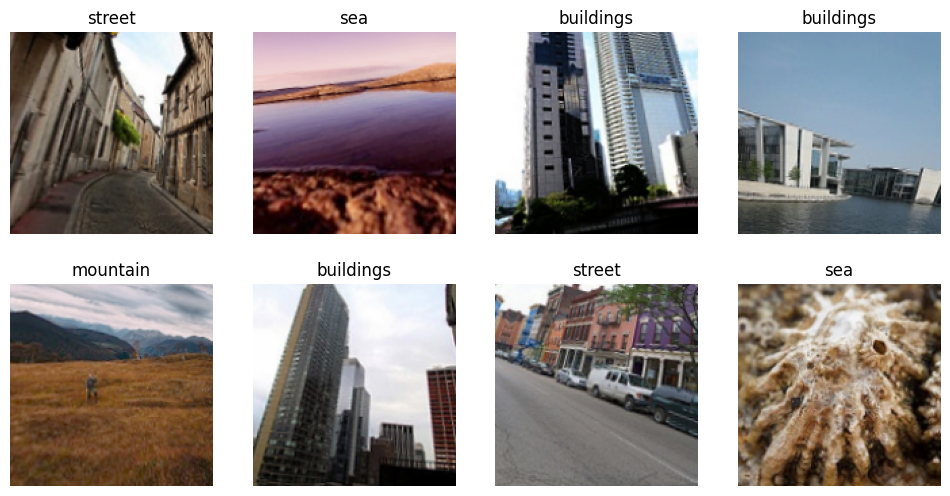

In [13]:
loaders = block.dataloaders(path)
loaders.train.show_batch(max_n=8, nrows=2)

In [14]:

timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [15]:
learn = vision_learner(loaders, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0008317637839354575)

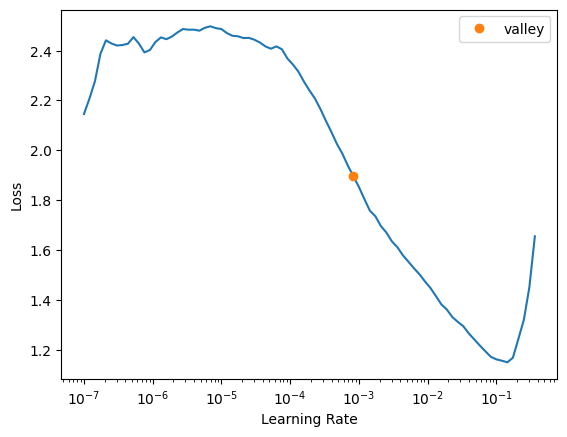

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.377816,0.190409,0.940655,00:19


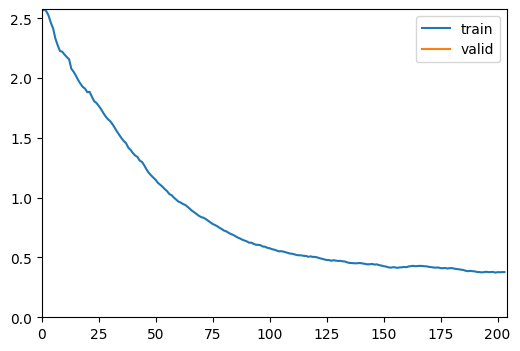

epoch,train_loss,valid_loss,accuracy,time
0,0.232334,0.173113,0.944326,00:20
1,0.218399,0.165235,0.945243,00:19
2,0.210052,0.163320,0.947385,00:20
3,0.183004,0.158341,0.950749,00:18
4,0.177399,0.168196,0.944631,00:18
5,0.166352,0.160509,0.944326,00:19
6,0.144698,0.157381,0.948302,00:19
7,0.135632,0.149323,0.953197,00:19
8,0.130250,0.151074,0.948302,00:18
9,0.125845,0.154658,0.948302,00:18


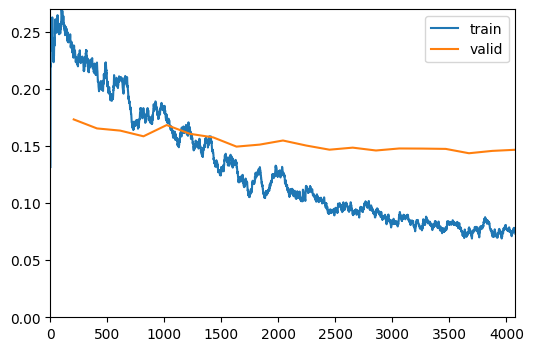

In [17]:
learn.fine_tune(20, base_lr=1e-3, cbs=[ShowGraphCallback()])

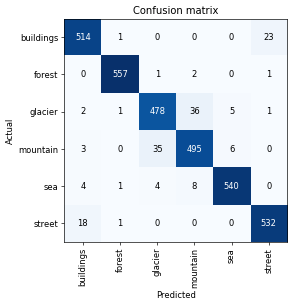

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

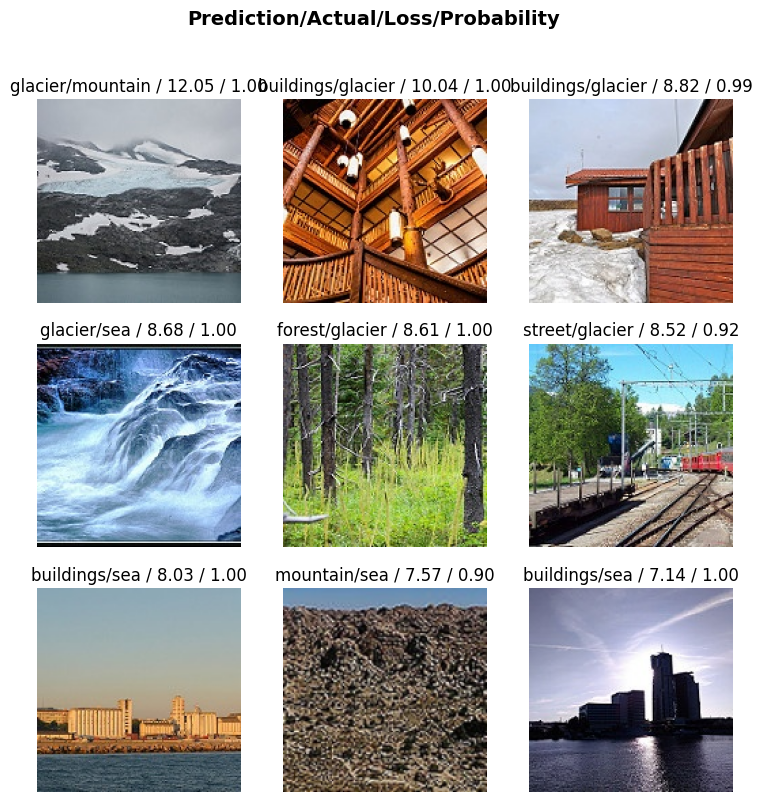

In [19]:
interp.plot_top_losses(9)

In [20]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn, height=256)
cleaner

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [22]:
interp.most_confused(min_val=5)

[('glacier', 'mountain', 36),
 ('mountain', 'glacier', 35),
 ('buildings', 'street', 23),
 ('street', 'buildings', 18),
 ('sea', 'mountain', 8),
 ('mountain', 'sea', 6),
 ('glacier', 'sea', 5)]

In [23]:
test_dl = learn.dls.test_dl(get_image_files('scene_classification/data/test_set/'))
learn.get_preds(dl=test_dl)

(TensorBase([[1.3167e-06, 3.4291e-05, 3.2422e-01, 6.7574e-01, 1.9158e-06,
              3.2716e-06],
             [8.0988e-07, 9.9901e-01, 9.6031e-04, 7.8661e-06, 2.2631e-05,
              3.3695e-07],
             [1.5808e-07, 5.6539e-07, 1.0000e+00, 2.6917e-07, 2.6212e-08,
              1.0347e-07],
             ...,
             [4.5038e-05, 7.4390e-06, 8.6190e-01, 1.3798e-01, 4.3060e-05,
              2.7424e-05],
             [2.0724e-02, 3.2781e-05, 1.2271e-06, 7.1449e-06, 7.9540e-07,
              9.7923e-01],
             [2.3170e-06, 1.8255e-07, 5.3053e-04, 8.0559e-05, 9.9938e-01,
              4.0665e-06]]),
 None)

mountain   67.57% confidence.   Image = 5115.jpg
forest   99.90% confidence.   Image = 7792.jpg
glacier   100.00% confidence.   Image = 2992.jpg
buildings   98.47% confidence.   Image = 8753.jpg
forest   99.99% confidence.   Image = 12964.jpg
mountain   73.45% confidence.   Image = 2622.jpg
street   99.98% confidence.   Image = 14084.jpg
sea   99.81% confidence.   Image = 22880.jpg
forest   100.00% confidence.   Image = 16780.jpg
forest   100.00% confidence.   Image = 8133.jpg


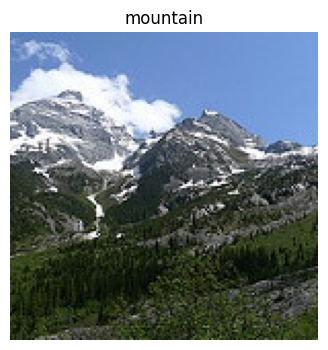

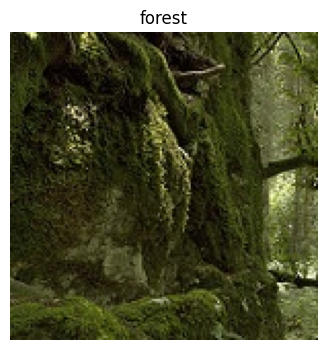

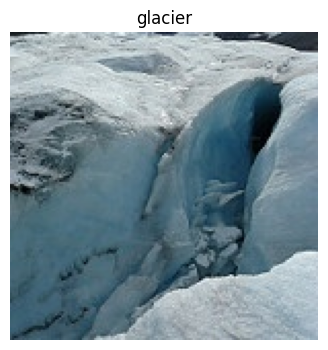

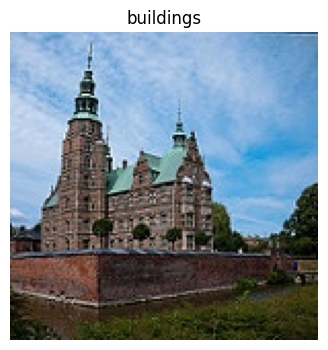

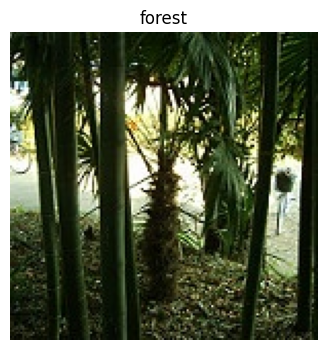

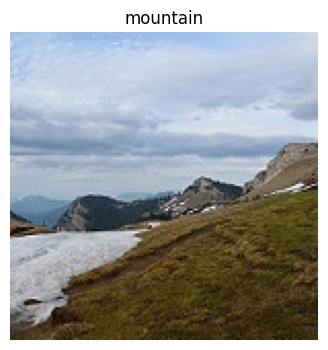

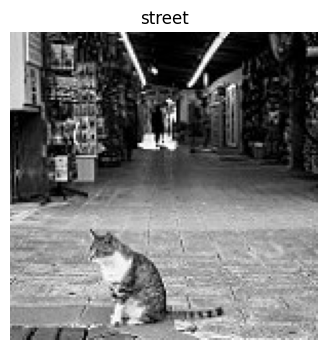

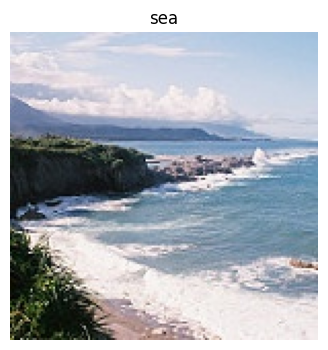

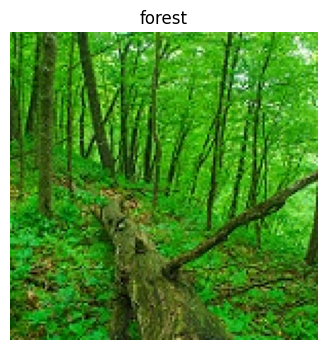

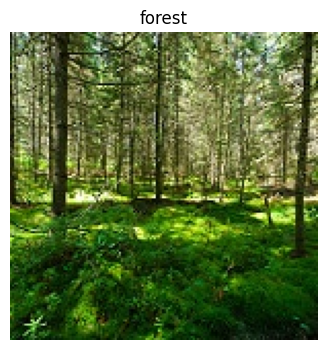

In [33]:
preds = learn.get_preds(dl=test_dl)
for index,item in enumerate(preds[0]):
    if index == 10:
        break
    prediction = learn.dls.categorize.decode(np.argmax(item))
    confidence = max(item)
    percent = float(confidence)
    print(f"{prediction}   {percent*100:.2f}% confidence.   Image = {test_dl.items[index].name}")
    im = PILImage.create(test_dl.items[index])
    im.thumbnail((150,150))
    im.show(title=f'Prediction {prediction}')

    